<a href="https://colab.research.google.com/github/akanksha0911/DeepLearning_6/blob/main/Akanksha_Rawat_AM6_PART1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By:Akanksha Rawat Assignment 6 Part1

##**Supervised contrastive learning  - Using new loss**

## **Ref:** 

https://keras.io/examples/vision/supervised-contrastive-learning/

https://towardsdatascience.com/contrastive-loss-for-supervised-classification-224ae35692e7

Supervised Contrastive Learning (Prannay Khosla et al.) is a training methodology that outperforms supervised training with crossentropy on classification tasks.

Essentially, training an image classification model with Supervised Contrastive Learning is performed in two phases:

1.   Training an encoder to learn to produce vector representations of input images 
such that representations of images in the same class will be more similar compared to representations of images in different classes.

2.   Training a classifier on top of the frozen encoder.

In [77]:
!pip install tensorflow-addons

In [78]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

## Prepare the data

In [79]:
num_classes = 10
input_shape = (32, 32, 3)

# Load the train and test data splits
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Using image data augmentation

In [80]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02),
        layers.RandomWidth(0.2),
        layers.RandomHeight(0.2),
    ]
)

# Setting the state of the normalization layer.
data_augmentation.layers[0].adapt(x_train)

## Build the encoder model

The encoder model takes the image as input and turns it into a 2048-dimensional
feature vector.

In [81]:

def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-encoder")
    return model


encoder = create_encoder()
encoder.summary()

learning_rate = 0.001
batch_size = 265
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.05

Model: "cifar10-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 3)         7         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
Total params: 23,564,807
Trainable params: 23,519,360
Non-trainable params: 45,447
_________________________________________________________________


## Build the classification model

The classification model adds a fully-connected layer on top of the encoder,
plus a softmax layer with the target classes.

In [82]:
def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model


## Experiment 1: Train the baseline classification model

In this experiment, a baseline classifier is trained as usual, i.e., the
encoder and the classifier parts are trained together as a single model
to minimize the crossentropy loss.

In [9]:
encoder = create_encoder()
classifier = create_classifier(encoder)
classifier.summary()

history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")


Model: "cifar10-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cifar10-encoder (Functional  (None, 2048)             23564807  
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                

## Experiment 2: Use supervised contrastive learning

In this experiment, the model is trained in two phases. In the first phase,
the encoder is pretrained to optimize the supervised contrastive loss,
described in [Prannay Khosla et al.](https://arxiv.org/abs/2004.11362).

In the second phase, the classifier is trained using the trained encoder with
its weights freezed; only the weights of fully-connected layers with the
softmax are optimized.

### 1. Supervised contrastive learning loss function

In [84]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="cifar-encoder_with_projection-head"
    )
    return model


In [85]:
x_train.shape

(50000, 32, 32, 3)

### 2. Pretrain the encoder

In [86]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

history = encoder_with_projection_head.fit(
    x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs
)

Model: "cifar-encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 cifar10-encoder (Functional  (None, 2048)             23564807  
 )                                                               
                                                                 
 dense_13 (Dense)            (None, 128)               262272    
                                                                 
Total params: 23,827,079
Trainable params: 23,781,632
Non-trainable params: 45,447
_________________________________________________________________
Epoch 1/50
189/189 [==============================] - 26s 114ms/step - loss: 5.3914
Epoch 2/50
189/189 [==============================] - 22s 116ms/step - loss: 5.1677
Epoch 3/50
189/189 [=========================

In [87]:
x_train.shape

(50000, 32, 32, 3)

### 3. Train the classifier with the frozen encoder

In [88]:
classifier = create_classifier(encoder, trainable=False)

history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Epoch 1/50
189/189 [==============================] - 10s 34ms/step - loss: 0.3635 - sparse_categorical_accuracy: 0.8984
Epoch 2/50
189/189 [==============================] - 6s 34ms/step - loss: 0.3168 - sparse_categorical_accuracy: 0.9052
Epoch 3/50
189/189 [==============================] - 6s 34ms/step - loss: 0.3006 - sparse_categorical_accuracy: 0.9071
Epoch 4/50
189/189 [==============================] - 7s 35ms/step - loss: 0.2916 - sparse_categorical_accuracy: 0.9100
Epoch 5/50
189/189 [==============================] - 7s 35ms/step - loss: 0.2953 - sparse_categorical_accuracy: 0.9081
Epoch 6/50
189/189 [==============================] - 7s 35ms/step - loss: 0.2830 - sparse_categorical_accuracy: 0.9114
Epoch 7/50
189/189 [==============================] - 7s 35ms/step - loss: 0.2835 - sparse_categorical_accuracy: 0.9130
Epoch 8/50
189/189 [==============================] - 7s 35ms/step - loss: 0.2895 - sparse_categorical_accuracy: 0.9091
Epoch 9/50
189/189 [===================

We get to an improved test accuracy.

## Conclusion

As shown in the experiments, using the supervised contrastive learning technique
outperformed the conventional technique in terms of the test accuracy. Note that
the same training budget (i.e., number of epochs) was given to each technique.
Supervised contrastive learning pays off when the encoder involves a complex
architecture, like ResNet, and multi-class problems with many labels.
In addition, large batch sizes and multi-layer projection heads
improve its effectiveness. See the [Supervised Contrastive Learning](https://arxiv.org/abs/2004.11362)
paper for more dettails.

# **Contrastive_loss**

Contrastive loss

Contrastive loss is widely-used in unsupervised and self-supervised learning. Originally developed by Hadsell et al. in 2016 from Yann LeCun’s group, this loss function operates on pairs of samples instead of individual samples. It defines a binary indicator Y for each pair of samples stating whether they should be deemed dissimilar (Y=0 if x_1, x_2 are deemed similar; Y=1 otherwise), and a learnable distance function D_W(x_1, x_2) between a pair of samples x_1, x_2, parameterized by the weights W in the neural network. The contrastive loss is defined as:


Contrast loss function

, where m>0 is a margin. The margin defines a radius around the embedding space of a sample so that dissimilar pairs of samples only contribute to the contrastive loss function if the distance D_W is within the margin.
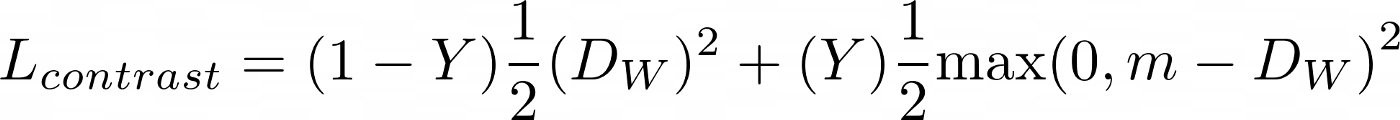

Intuitively, this loss function encourages the neural network to learn a embedding to place samples with the same labels close to each other, while distancing the samples with different labels in the embedding space.

In [27]:
import datetime
import numpy as np
import tensorflow as tf
print(tf.__version__)
import tensorflow_addons as tfa

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

2.8.0


In [28]:
import tensorflow as tf


class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''

    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])


class DenseLeakyReluLayer(tf.keras.layers.Layer):
    '''A dense layer followed by a LeakyRelu layer
    '''

    def __init__(self, n, alpha=0.3):
        super(DenseLeakyReluLayer, self).__init__()
        self.dense = tf.keras.layers.Dense(n, activation=None)
        self.lrelu = tf.keras.layers.LeakyReLU(alpha=alpha)

    def call(self, input_tensor):
        x = self.dense(input_tensor)
        return self.lrelu(x)


class Encoder(tf.keras.Model):
    '''An encoder network, E(·), which maps an augmented image x to a representation vector, r = E(x) ∈ R^{DE}
    '''

    def __init__(self, normalize=True, activation='relu'):
        super(Encoder, self).__init__(name='')
        if activation == 'leaky_relu':
            self.hidden1 = DenseLeakyReluLayer(256)
            self.hidden2 = DenseLeakyReluLayer(256)
        else:
            self.hidden1 = tf.keras.layers.Dense(256, activation=activation)
            self.hidden2 = tf.keras.layers.Dense(256, activation=activation)

        self.normalize = normalize
        if self.normalize:
            self.norm = UnitNormLayer()

    def call(self, input_tensor, training=False):
        x = self.hidden1(input_tensor, training=training)
        x = self.hidden2(x, training=training)
        if self.normalize:
            x = self.norm(x)
        return x


class Projector(tf.keras.Model):
    '''
    A projection network, P(·), which maps the normalized representation vector r into a vector z = P(r) ∈ R^{DP} 
    suitable for computation of the contrastive loss.
    '''

    def __init__(self, n, normalize=True, activation='relu'):
        super(Projector, self).__init__(name='')
        if activation == 'leaky_relu':
            self.dense = DenseLeakyReluLayer(256)
            self.dense2 = DenseLeakyReluLayer(256)
        else:
            self.dense = tf.keras.layers.Dense(256, activation=activation)
            self.dense2 = tf.keras.layers.Dense(256, activation=activation)

        self.normalize = normalize
        if self.normalize:
            self.norm = UnitNormLayer()

    def call(self, input_tensor, training=False):
        x = self.dense(input_tensor, training=training)
        x = self.dense2(x, training=training)
        if self.normalize:
            x = self.norm(x)
        return x


class SoftmaxPred(tf.keras.Model):
    '''For stage 2, simply a softmax on top of the Encoder.
    '''

    def __init__(self, num_classes=10):
        super(SoftmaxPred, self).__init__(name='')
        self.dense = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, input_tensor, training=False):
        return self.dense(input_tensor, training=training)


class MLP(tf.keras.Model):
    '''A simple baseline MLP with the same architecture to Encoder + Softmax/Regression output.
    '''

    def __init__(self, num_classes=10, normalize=True, regress=False, activation='relu'):
        super(MLP, self).__init__(name='')
        if activation == 'leaky_relu':
            self.hidden1 = DenseLeakyReluLayer(256)
            self.hidden2 = DenseLeakyReluLayer(256)
        else:
            self.hidden1 = tf.keras.layers.Dense(256, activation=activation)
            self.hidden2 = tf.keras.layers.Dense(256, activation=activation)
        self.normalize = normalize
        if self.normalize:
            self.norm = UnitNormLayer()
        if not regress:
            self.output_layer = tf.keras.layers.Dense(
                num_classes, activation='softmax')
        else:
            self.output_layer = tf.keras.layers.Dense(1)

    def call(self, input_tensor, training=False):
        x = self.hidden1(input_tensor, training=training)
        x = self.hidden2(x, training=training)
        if self.normalize:
            x = self.norm(x)
        preds = self.output_layer(x, training=training)
        return preds

    def get_last_hidden(self, input_tensor):
        '''Get the last hidden layer before prediction.
        '''
        x = self.hidden1(input_tensor, training=False)
        x = self.hidden2(x, training=False)
        if self.normalize:
            x = self.norm(x)
        return x

In [51]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa


def pdist_euclidean(A):
    # Euclidean pdist
    # https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
    r = tf.reduce_sum(A*A, 1)

    # turn r into column vector
    r = tf.reshape(r, [-1, 1])
    D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    return tf.sqrt(D)


def square_to_vec(D):
    '''Convert a squared form pdist matrix to vector form.
    '''
    n = D.shape[0]
    triu_idx = np.triu_indices(n, k=1)
    d_vec = tf.gather_nd(D, list(zip(triu_idx[0], triu_idx[1])))
    return d_vec


def get_contrast_batch_labels(y):
    '''
    Make contrast labels by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:   
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    y_col_vec = tf.reshape(tf.cast(y, tf.float32), [-1, 1])
    D_y = pdist_euclidean(y_col_vec)
    d_y = square_to_vec(D_y)
    y_contrasts = tf.cast(d_y == 0, tf.int32)
    return y_contrasts


def get_contrast_batch_labels_regression(y):
    '''
    Make contrast labels for regression by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:   
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    raise NotImplementedError


def max_margin_contrastive_loss(z, y, margin=1.0, metric='euclidean'):
    '''
    Wrapper for the maximum margin contrastive loss (Hadsell et al. 2006)
    `tfa.losses.contrastive_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
        metric: one of ('euclidean', 'cosine')
    '''
    # compute pair-wise distance matrix
    if metric == 'euclidean':
        D = pdist_euclidean(z)
    elif metric == 'cosine':
        D = 1 - tf.matmul(z, z, transpose_a=False, transpose_b=True)
    # convert squareform matrix to vector form
    d_vec = square_to_vec(D)
    # make contrastive labels
    y_contrasts = get_contrast_batch_labels(y)
    loss = tfa.losses.contrastive_loss(y_contrasts, d_vec, margin=margin)
    # exploding/varnishing gradients on large batch?
    return tf.reduce_mean(loss)


def multiclass_npairs_loss(z, y):
    '''
    Wrapper for the multiclass N-pair loss (Sohn 2016)
    `tfa.losses.npairs_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    # cosine similarity matrix
    S = tf.matmul(z, z, transpose_a=False, transpose_b=True)
    loss = tfa.losses.npairs_loss(y, S)
    return loss


def triplet_loss(z, y, margin=1.0, kind='hard'):
    '''
    Wrapper for the triplet losses 
    `tfa.losses.triplet_hard_loss` and `tfa.losses.triplet_semihard_loss`
    Args:
        z: hidden vector of shape [bsz, n_features], assumes it is l2-normalized.
        y: ground truth of shape [bsz].    
    '''
    if kind == 'hard':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=False)
    elif kind == 'soft':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=True)
    elif kind == 'semihard':
        loss = tfa.losses.triplet_semihard_loss(y, z, margin=margin)
    return loss


def supervised_nt_xent_loss(z, y, temperature=0.5, base_temperature=0.07):
    '''
    Supervised normalized temperature-scaled cross entropy loss. 
    A variant of Multi-class N-pair Loss from (Sohn 2016)
    Later used in SimCLR (Chen et al. 2020, Khosla et al. 2020).
    Implementation modified from: 
        - https://github.com/google-research/simclr/blob/master/objective.py
        - https://github.com/HobbitLong/SupContrast/blob/master/losses.py
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    batch_size = tf.shape(z)[0]
    contrast_count = 1
    anchor_count = contrast_count
    y = tf.expand_dims(y, -1)

    # mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
    #     has the same class as sample i. Can be asymmetric.
    mask = tf.cast(tf.equal(y, tf.transpose(y)), tf.float32)
    anchor_dot_contrast = tf.divide(
        tf.matmul(z, tf.transpose(z)),
        temperature
    )
    # # for numerical stability
    logits_max = tf.reduce_max(anchor_dot_contrast, axis=1, keepdims=True)
    logits = anchor_dot_contrast - logits_max
    # # tile mask
    logits_mask = tf.ones_like(mask) - tf.eye(batch_size)
    mask = mask * logits_mask
    # compute log_prob
    exp_logits = tf.exp(logits) * logits_mask
    log_prob = logits - \
        tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True))

    # compute mean of log-likelihood over positive
    # this may introduce NaNs due to zero division,
    # when a class only has one example in the batch
    mask_sum = tf.reduce_sum(mask, axis=1)
    mean_log_prob_pos = tf.reduce_sum(
        mask * log_prob, axis=1)[mask_sum > 0] / mask_sum[mask_sum > 0]

    # loss
    loss = -(temperature / base_temperature) * mean_log_prob_pos
    # loss = tf.reduce_mean(tf.reshape(loss, [anchor_count, batch_size]))
    loss = tf.reduce_mean(loss)
    return loss

In [30]:
%load_ext autoreload
%autoreload 2
# from model import *
# from contrast_loss_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [32]:
# global configs
EPOCHS = 20
DATA = 'mnist-regression'
NORMALIZE_EMBEDDING = True
# NORMALIZE_EMBEDDING = False
N_DATA_TRAIN = 60000
# N_DATA_TRAIN = 10000
BATCH_SIZE = 32
PROJECTION_DIM = 128
WRITE_SUMMARY = False
ACTIVATION = 'leaky_relu'

In [33]:
!mkdir -p logs/

In [34]:
optimizer = tf.keras.optimizers.Adam()

## **Load MNIST data**

In [35]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [36]:
# simulate low data regime for training
n_train = x_train.shape[0]
shuffle_idx = np.arange(n_train)
np.random.shuffle(shuffle_idx)

x_train = x_train[shuffle_idx][:N_DATA_TRAIN]
y_train = y_train[shuffle_idx][:N_DATA_TRAIN]
print(x_train.shape, y_train.shape)

(60000, 784) (60000,)


In [37]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(5000).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

## **Train baseline model**

In [38]:
mlp = MLP(normalize=NORMALIZE_EMBEDDING, regress=True, activation=ACTIVATION)

In [39]:
mse_loss_obj = tf.keras.losses.MeanSquaredError()
# mse_loss_obj = tf.keras.losses.MeanSquaredLogarithmicError()

In [40]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_mae = tf.keras.metrics.MeanAbsoluteError(name='train_MAE')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_mae = tf.keras.metrics.MeanAbsoluteError(name='test_MAE')

In [41]:
@tf.function
def train_step_baseline(x, y):
    with tf.GradientTape() as tape:
        y_preds = mlp(x, training=True)
        loss = mse_loss_obj(y, y_preds)

    gradients = tape.gradient(loss, 
                              mlp.trainable_variables)
    optimizer.apply_gradients(zip(gradients, 
                                  mlp.trainable_variables))

    train_loss(loss)
    train_mae(y, y_preds)

In [42]:
@tf.function
def test_step_baseline(x, y):
    y_preds = mlp(x, training=False)
    t_loss = mse_loss_obj(y, y_preds)
    test_loss(t_loss)
    test_mae(y, y_preds)

In [43]:
model_name = 'baseline'
if WRITE_SUMMARY:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/%s/%s/%s/train' % (model_name, DATA, current_time)
    test_log_dir = 'logs/%s/%s/%s/test' % (model_name, DATA, current_time)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [44]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_mae.reset_states()
    test_loss.reset_states()
    test_mae.reset_states()

    for x, y in train_ds:
        train_step_baseline(x, y)
        
    if WRITE_SUMMARY:
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('MAE', train_mae.result(), step=epoch)        

    for x_te, y_te in test_ds:
        test_step_baseline(x_te, y_te)

    if WRITE_SUMMARY:
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('MAE', test_mae.result(), step=epoch)        

    template = 'Epoch {}, Loss: {}, MAE: {}, Test Loss: {}, Test MAE: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_mae.result(),
                        test_loss.result(),
                        test_mae.result()))

Epoch 1, Loss: 2.8246989250183105, MAE: 1.071571707725525, Test Loss: 0.8436963558197021, Test MAE: 0.552854061126709
Epoch 2, Loss: 0.7001720070838928, MAE: 0.49671101570129395, Test Loss: 0.7341722249984741, Test MAE: 0.4912884533405304
Epoch 3, Loss: 0.5524783134460449, MAE: 0.4357258677482605, Test Loss: 0.55985426902771, Test MAE: 0.4140947759151459
Epoch 4, Loss: 0.464947372674942, MAE: 0.3948993384838104, Test Loss: 0.5001177191734314, Test MAE: 0.3821302056312561
Epoch 5, Loss: 0.4134018123149872, MAE: 0.37218496203422546, Test Loss: 0.5217092633247375, Test MAE: 0.3895546793937683
Epoch 6, Loss: 0.36315056681632996, MAE: 0.34901660680770874, Test Loss: 0.4424537420272827, Test MAE: 0.3381458818912506
Epoch 7, Loss: 0.3296751081943512, MAE: 0.3304901719093323, Test Loss: 0.4594055712223053, Test MAE: 0.3522217273712158
Epoch 8, Loss: 0.2978668510913849, MAE: 0.31705811619758606, Test Loss: 0.4584246873855591, Test MAE: 0.35893088579177856
Epoch 9, Loss: 0.27308419346809387, MAE

## **Stage 1: train encoder with contrastive loss**

In [45]:
encoder = Encoder(normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)

In [46]:
projector = Projector(PROJECTION_DIM, normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)

In [47]:
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_mae = tf.keras.metrics.MeanAbsoluteError(name='train_contrast_MAE')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_mae = tf.keras.metrics.MeanAbsoluteError(name='test_contrast_MAE')

In [48]:
@tf.function
# train step for the contrast loss
def train_step_contrast(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:
        y_contrasts = get_contrast_batch_labels_regression(y)
        
        r = encoder(x, training=True)
        z = projector(r, training=True)
        
        D = pdist_euclidean(z)
        d_vec = square_to_vec(D)
        loss = tf.losses.mean_absolute_error(y_contrasts, d_vec)
#         loss = tf.losses.mean_squared_error(y_contrasts, d_vec)
#         loss = mse_loss_obj(y_contrasts, d_vec)

    gradients = tape.gradient(loss, 
                              encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(gradients, 
                                  encoder.trainable_variables + projector.trainable_variables))

    train_loss(loss)
    train_mae(y_contrasts, d_vec)

In [49]:
@tf.function
def test_step_contrast(x, y):
    y_contrasts = get_contrast_batch_labels_regression(y)

    r = encoder(x, training=False)
    z = projector(r, training=False)

    D = pdist_euclidean(z)
    d_vec = square_to_vec(D)
    t_loss = tf.losses.mean_absolute_error(y_contrasts, d_vec)
#     t_loss = tf.losses.mean_squared_error(y_contrasts, d_vec)
#     t_loss = mse_loss_obj(y_contrasts, d_vec)

    test_loss(t_loss)
    test_mae(y_contrasts, d_vec)

In [53]:
x_tr_proj = projector(encoder(x_train))
x_tr_proj.shape

TensorShape([60000, 256])

In [54]:
x_te_proj = projector(encoder(x_test))
x_te_proj.shape

TensorShape([10000, 256])

In [55]:
# convert tensor to np.array
x_tr_proj = x_tr_proj.numpy()
x_te_proj = x_te_proj.numpy()
print(x_tr_proj.shape, x_te_proj.shape)

(60000, 256) (10000, 256)


In [56]:
x_test.shape

(10000, 784)

## **Check learned embedding**

In [57]:
from sklearn.decomposition import PCA

In [58]:
# do PCA for the projected data
pca = PCA(n_components=2)
pca.fit(x_tr_proj)
x_te_proj_pca = pca.transform(x_te_proj)
x_te_proj_pca.shape

(10000, 2)

In [59]:
# do PCA for original data
pca = PCA(n_components=2)
pca.fit(x_train)
x_te_pca = pca.transform(x_test)
x_te_pca.shape

(10000, 2)

In [60]:
x_te_proj_df = pd.DataFrame(x_te_proj[:, :2], columns=['Proj1', 'Proj2'])
x_te_proj_df['label'] = y_test
# x_te_proj_df.head()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


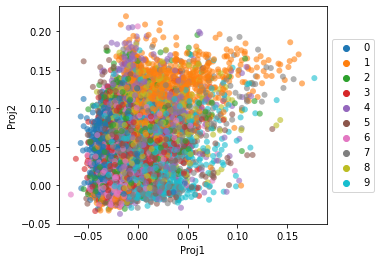

In [61]:
ax = sns.scatterplot('Proj1', 'Proj2', data=x_te_proj_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


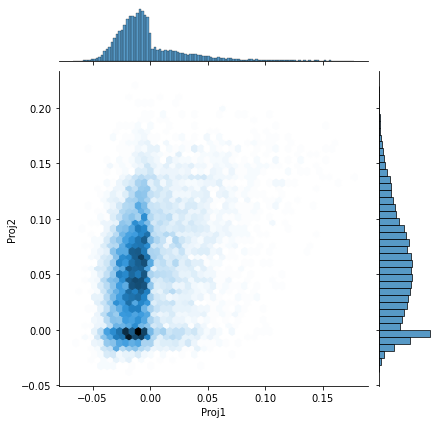

In [62]:
sns.jointplot('Proj1', 'Proj2', data=x_te_proj_df,
              kind="hex"
             );

In [63]:
x_te_proj_pca_df = pd.DataFrame(x_te_proj_pca, columns=['PC1', 'PC2'])
x_te_proj_pca_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


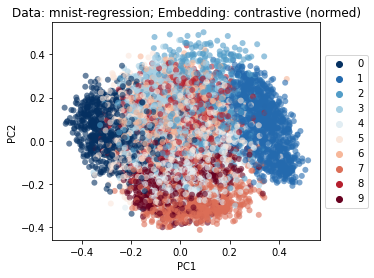

In [64]:
ax = sns.scatterplot('PC1', 'PC2', data=x_te_proj_pca_df,
#                 palette='tab10',
                     palette='RdBu_r',
                     legend='full',
                hue='label',
                linewidth=0,
                alpha=0.6
               );

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
title = 'Data: %s; Embedding: contrastive'% DATA
if NORMALIZE_EMBEDDING:
    title = 'Data: %s; Embedding: contrastive (normed)'% DATA
ax.set_title(title);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


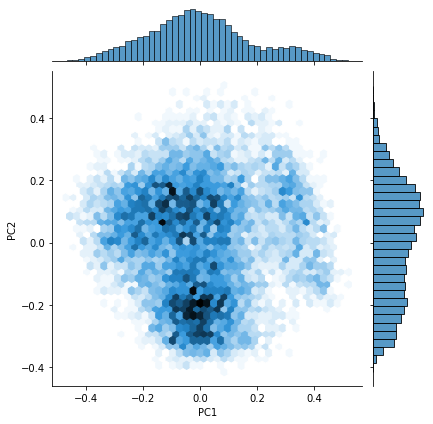

In [65]:
sns.jointplot('PC1', 'PC2', data=x_te_proj_pca_df,
              kind="hex"
             )

In [66]:
x_te_pca_df = pd.DataFrame(x_te_pca, columns=['PC1', 'PC2'])
x_te_pca_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


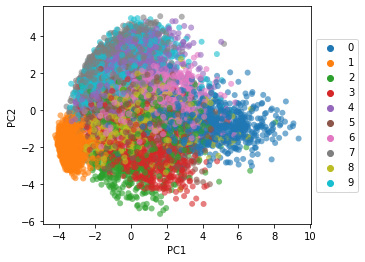

In [67]:
ax = sns.scatterplot('PC1', 'PC2', data=x_te_pca_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


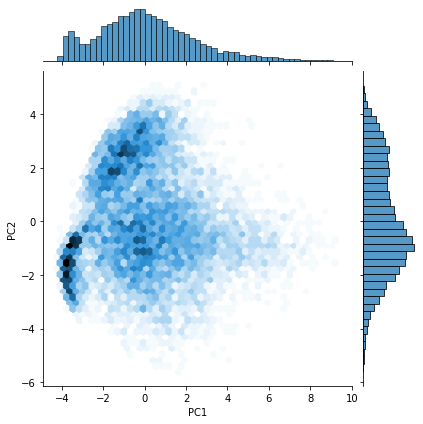

In [68]:
sns.jointplot('PC1', 'PC2', data=x_te_pca_df,
              kind="hex"
             );

## **Stage 2: freeze the learned representations and then learn a classifier on a linear layer using a softmax loss**

In [69]:
dense1 = tf.keras.layers.Dense(1)

In [70]:
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_mae = tf.keras.metrics.MeanAbsoluteError(name='train_MAE')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_mae = tf.keras.metrics.MeanAbsoluteError(name='test_MAE')

In [71]:
mse_loss_obj = tf.keras.losses.MeanSquaredError()
# mse_loss_obj = tf.keras.losses.MeanSquaredLogarithmicError()

In [72]:
@tf.function
# train step for the 2nd stage
def train_step(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = encoder(x, training=False)
        y_preds = dense1(r, training=True)
        loss = mse_loss_obj(y, y_preds)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss, 
                              dense1.trainable_variables) 
    optimizer.apply_gradients(zip(gradients, 
                                  dense1.trainable_variables))

    train_loss(loss)
    train_mae(y, y_preds)

In [73]:
@tf.function
def test_step(x, y):
    r = encoder(x, training=False)
    y_preds = dense1(r, training=False)

    t_loss = mse_loss_obj(y, y_preds)

    test_loss(t_loss)
    test_mae(y, y_preds)

In [74]:
model_name = 'contrast_loss_model'
if WRITE_SUMMARY:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/%s/%s/%s/train' % (model_name, DATA, current_time)
    test_log_dir = 'logs/%s/%s/%s/test' % (model_name, DATA, current_time)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [75]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_mae.reset_states()
    test_loss.reset_states()
    test_mae.reset_states()

    for x, y in train_ds:
        train_step(x, y)

    if WRITE_SUMMARY:
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_mae.result(), step=epoch)        
        
    for x_te, y_te in test_ds:
        test_step(x_te, y_te)

    if WRITE_SUMMARY:
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_mae.result(), step=epoch)        
        
    template = 'Epoch {}, Loss: {}, MAE: {}, Test Loss: {}, Test MAE: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_mae.result(),
                        test_loss.result(),
                        test_mae.result()))

Epoch 1, Loss: 6.0559916496276855, MAE: 2.099452018737793, Test Loss: 4.430466651916504, Test MAE: 1.7850139141082764
Epoch 2, Loss: 4.304898262023926, MAE: 1.736541509628296, Test Loss: 3.9096932411193848, Test MAE: 1.627925992012024
Epoch 3, Loss: 3.9522452354431152, MAE: 1.627337098121643, Test Loss: 3.6790993213653564, Test MAE: 1.556402325630188
Epoch 4, Loss: 3.761831521987915, MAE: 1.5694191455841064, Test Loss: 3.540748119354248, Test MAE: 1.515015721321106
Epoch 5, Loss: 3.635193347930908, MAE: 1.5326553583145142, Test Loss: 3.438650131225586, Test MAE: 1.4839752912521362
Epoch 6, Loss: 3.5424277782440186, MAE: 1.5058820247650146, Test Loss: 3.3639087677001953, Test MAE: 1.4621883630752563
Epoch 7, Loss: 3.470062494277954, MAE: 1.4853076934814453, Test Loss: 3.3066320419311523, Test MAE: 1.4453989267349243
Epoch 8, Loss: 3.4098291397094727, MAE: 1.4681116342544556, Test Loss: 3.2554707527160645, Test MAE: 1.4288407564163208
Epoch 9, Loss: 3.359616756439209, MAE: 1.453695178031

In [76]:
test_mae.result().numpy()

1.3445824

Contrastive loss functions were invented for metric learning, which intends to learn similarity functions that measure the similarity or distance between a pair of objects. In the context of classification, the desired metric would render a pair of examples with the same label more similar than a pair of examples with different labels. Deep metric learning involves deep neural networks to embed data points to a lower-dimensional space with nonlinearity, then uses contrastive loss function to optimize the parameters in the neural networks